In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

from summer2 import CompartmentalModel
from summer2.parameters import Parameter

In [2]:
def build_seir_model(
    config: dict,
) -> CompartmentalModel:
    
    # Model characteristics
    compartments = (
        "Susceptible", 
        "Pre-infectious", 
        "Infectious", 
        "Immune"
    )
    model = CompartmentalModel(
        times=(0., config["end_time"]),
        compartments=compartments,
        infectious_compartments=("Infectious",),
    )
    model.set_initial_population(
        distribution={
            "Susceptible": config["total_population"] - config["infectious_seed"], 
            "Infectious": config["infectious_seed"]
        }
    )
    
    # Transitions
    infectious_period = Parameter("infectious_period")
    model.add_infection_frequency_flow(
        name="infection", 
        contact_rate=Parameter("r0") / infectious_period,
        source="Susceptible",
        dest="Pre-infectious"
    )
    model.add_transition_flow(
        name="progression", 
        fractional_rate=1. / Parameter("latent_period"),
        source="Pre-infectious", 
        dest="Infectious"
    )
    model.add_transition_flow(
        name="recovery", 
        fractional_rate=1. / infectious_period,
        source="Infectious", 
        dest="Immune"
    )
    
    # Output
    model.request_output_for_flow(
        name="incidence", 
        flow_name="progression",
        raw_results=True,
    )
    
    return model

In [3]:
model_config = {
    "total_population": 1e5,
    "infectious_seed": 1.,
    "end_time": 120.,
}

parameters = {
    "r0": 13.,
    "latent_period": 8.,
    "infectious_period": 7.,
}

In [4]:
measles_model = build_seir_model(model_config)
measles_model.run(parameters=parameters)
measles_outputs = pd.DataFrame()
measles_outputs["Prevalence of infectious individuals"] = measles_model.get_outputs_df()["Infectious"]
measles_outputs["New infectious individuals/day"] = measles_model.get_derived_outputs_df()["incidence"]
measles_outputs["Cumulative number of infectious individuals"] = measles_outputs.loc[:, "New infectious individuals/day"].cumsum()

#### Panel (a) - measles

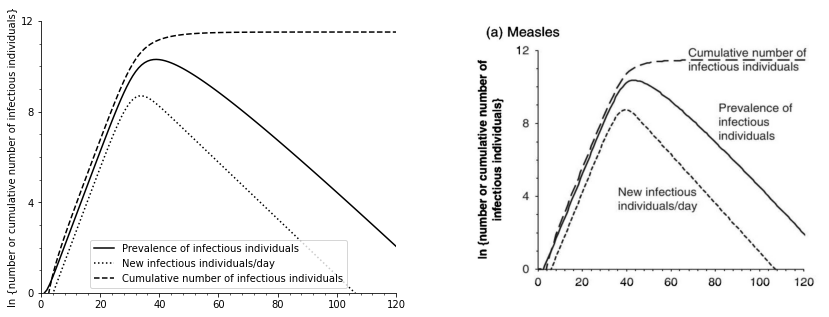

In [5]:
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(14, 5))
log_outputs = np.log(measles_outputs[1:])
line_styles = ("-", ":", "--")

for i_ind, indicator in enumerate(measles_outputs.columns):
    left_ax.plot(
        measles_model.times[1:],
        log_outputs[indicator],
        label=indicator,
        linestyle=line_styles[i_ind],
        color="k",
    )
left_ax.set_xlim(0., 120.)
left_ax.xaxis.set_minor_locator(AutoMinorLocator(5))
left_ax.set_ylim(0., 12.)
left_ax.set_ylabel("ln {number or cumulative number of infectious individuals}")
left_ax.set_yticks(range(0, 16, 4))
left_ax.yaxis.set_minor_locator(AutoMinorLocator(4))
left_ax.legend()
left_ax.spines.top.set_visible(False)
left_ax.spines.right.set_visible(False)

image = plt.imread("./figures/fig_4_6a.jpg")
right_ax.axis("off")
right_ax.imshow(image, aspect="auto");

In [6]:
parameters = {
    "r0": 2.,
    "latent_period": 2.,
    "infectious_period": 2.,
}

In [7]:
flu_model = build_seir_model(model_config)
flu_model.run(parameters=parameters)
flu_outputs = pd.DataFrame()
flu_outputs["Prevalence of infectious individuals"] = flu_model.get_outputs_df()["Infectious"]
flu_outputs["New infectious individuals/day"] = flu_model.get_derived_outputs_df()["incidence"]
flu_outputs["Cumulative number of infectious individuals"] = flu_outputs.loc[:, "New infectious individuals/day"].cumsum()

#### Panel (b) - influenza

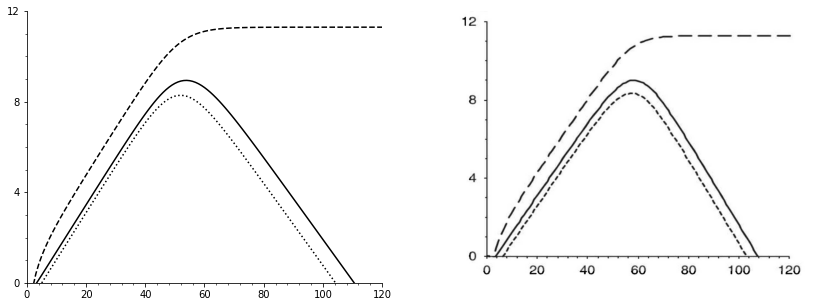

In [8]:
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(14, 5))
log_outputs = np.log(flu_outputs[1:])
line_styles = ("-", ":", "--")

for i_ind, indicator in enumerate(flu_outputs.columns):
    left_ax.plot(
        flu_model.times[1:],
        log_outputs[indicator],
        linestyle=line_styles[i_ind],
        color="k",
    )
left_ax.set_xlim(0., 120.)
left_ax.xaxis.set_minor_locator(AutoMinorLocator(5))
left_ax.set_ylim(0., 12.)
left_ax.set_yticks(range(0, 16, 4))
left_ax.yaxis.set_minor_locator(AutoMinorLocator(4))
left_ax.spines.top.set_visible(False)
left_ax.spines.right.set_visible(False)

image = plt.imread("./figures/fig_4_6b.jpg")
right_ax.axis("off")
right_ax.imshow(image, aspect="auto");